In [ ]:
# Imports e Criação do ambiente

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from random import shuffle
from sklearn.model_selection import KFold
from pathlib import Path
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
import os
from kaggle_datasets import KaggleDatasets



#Esse notebook usará a estrutura de TPUs oferecida pelo Kaggle. O código abaixo serve para conectar o notebook a ela.
#Importante observar que a TPU só é atividade quando o modelo está treinando.
#Durante o resto do tempo, é utilizada a CPU padrão.

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 30

In [3]:
#Fixando algumas variáveis para aumentar a reprodutibilidade dos modelos.
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(111)
tf.random.set_seed(111)

In [4]:
#Buscando todos os paths das imagens e juntando em uma só lista.
#Como a quantidade de imagens pré separadas para treino, teste e validação varia muito, vamos redistribuí-las.

path_train_normal = Path('../input/chest-xray-pneumonia/chest_xray/train/NORMAL')
path_train_pneumonia = Path('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')

train_normal_cases = path_train_normal.glob('*.jpeg')
train_pneumonia_cases = path_train_pneumonia.glob('*.jpeg')

path_test_normal = Path('../input/chest-xray-pneumonia/chest_xray/test/NORMAL')
path_test_pneumonia = Path('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA')

test_normal_cases = path_test_normal.glob('*.jpeg')
test_pneumonia_cases = path_test_pneumonia.glob('*.jpeg')

path_val_normal = Path('chest_xray/val/NORMAL')
path_val_pneumonia = Path('chest_xray/val/PNEUMONIA')

val_normal_cases = path_val_normal.glob('*.jpeg')
val_pneumonia_cases = path_val_pneumonia.glob('*.jpeg')

total_data = []

for img in train_normal_cases:
    total_data.append((img,0))
    
for img in train_pneumonia_cases:
    total_data.append((img,1))
    
for img in test_normal_cases:
    total_data.append((img,0))
    
for img in test_pneumonia_cases:
    total_data.append((img,1))

for img in val_normal_cases:
    total_data.append((img,0))
    
for img in val_pneumonia_cases:
    total_data.append((img,1))

In [5]:
def generate_Data(data, n_epochs=10, image_size=(180,180)):
    i=0
    file_list = data
    shuffle(file_list)
    images = [] 
    labels=[]  
 
    while i<len(file_list):    
                sample = file_list[i]   
                label=sample[1]    
                i += 1       
                image=cv2.imread(str(sample[0]))    
                image = cv2.resize(image,image_size)           
                image=(image.astype(float) - 255) / 255  
                images.append(image)     
                labels.append(label)
    images=np.array(images)
    labels=np.array(labels)
    return images, labels

In [6]:
def data_generator(data,batch_size=16 * strategy.num_replicas_in_sync, n_epochs=25, image_size=(180,180)):
    i=0
    file_list = data
    shuffle(file_list)
    epoch=1
    while epoch <= n_epochs:
        imageBatch = [] 
        labelBatch=[]  
        for j in range(batch_size):  
            if(i<len(file_list)):    
                sample = file_list[i]   
                label=sample[1]    
                i += 1       
                image=cv2.imread(str(sample[0]))    
                image = cv2.resize(image,image_size)           
                image=(image.astype(float) - 255) / 255  
                imageBatch.append(image)     
                labelBatch.append(label)
                    
                
            else:
                i=0
                epoch += 1
            #print(epoch, i)
        image_batch=np.array(imageBatch)
        labelBatch=np.array(labelBatch)
        yield (image_batch,labelBatch)

In [7]:
def new_model(bias_initializer='zeros'):
  model = Sequential([Conv2D(16, 3, activation='relu', padding='same',input_shape=(180,180,3)),
                      Conv2D(16, 3, activation='relu', padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(),
              
                      Conv2D(32, 3, activation='relu', padding='same'),
                      Conv2D(32, 3, activation='relu', padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(),

                      Conv2D(64, 3, activation='relu', padding='same',input_shape=(180,180,3)),
                      Conv2D(64, 3, activation='relu', padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(),

                      Conv2D(128, 3, activation='relu', padding='same',input_shape=(180,180,3)),
                      Conv2D(128, 3, activation='relu', padding='same'),
                      BatchNormalization(),
                      MaxPooling2D(),

                      Flatten(),
                      Dense(512, activation='relu'),
                      Dropout(0.5),

                      Dense(256, activation='relu'),
                      Dropout(0.5),

                      Dense(64, activation='relu'),
                      Dropout(0.3),

                      Dense(1, activation='sigmoid', bias_initializer=bias_initializer)
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=METRICS)
  
  return model

In [8]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    #plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.show()

In [9]:
def plot_cm(labels, predictions, p=0.5):
  cm = sklearn.metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [10]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

A partir daqui é preciso escolher para onde se vai no notebook, porque a RAM não suportará rodar todo o código. As opções são: continuar para a geração dos dados, logo abaixo, e testar os modelos sem cross validation ou ir direto para o cross validation e gerar a estrutura de dados que está lá.

# Sem Cross Validation

In [ ]:
len(total_data)

In [ ]:
data_train, data_pretest = train_test_split(total_data, test_size=0.3, train_size=0.7, random_state=12)

In [ ]:
data_train[0]

In [5]:
data_test, data_val = train_test_split(data_pretest, test_size=0.33, train_size=0.67, random_state=12)

NameError: name 'data_pretest' is not defined

In [ ]:
data_test[0]

In [ ]:
print(f'Train size: {len(data_train)}')
print(f'Test size: {len(data_test)}')
print(f'Validaiton size: {len(data_val)}')

In [ ]:
x_train, y_train = generate_Data(data_train)

In [ ]:
x_test, y_test = generate_Data(data_test)
x_val, y_val = generate_Data(data_val)

## Baseline

In [ ]:
with strategy.scope():  #Sempre será necessária chamar essa função na hora de treinar um modelo, pois ela ativa a TPU.

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
    
    baseline_model = new_model()
    
    baseline_history = baseline_model.fit(x_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_test, y_test))

In [ ]:
train_predictions_baseline = baseline_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_baseline = baseline_model.predict(x_test, batch_size=BATCH_SIZE)
val_predictions_baseline = baseline_model.predict(x_val, batch_size=BATCH_SIZE)

In [ ]:
#Matrizes de confusão para treino, teste e validação.

plot_cm(y_train, train_predictions_baseline)
plot_cm(y_test, test_predictions_baseline)
plot_cm(y_val, val_predictions_baseline)

In [ ]:
#Curvas ROC para treino, teste e validação

train_baseline_results = baseline_model.evaluate(x_train, y_train,
                                  batch_size=BATCH_SIZE)
test_baseline_results = baseline_model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE)
val_baseline_results = baseline_model.evaluate(x_val, y_val,
                                  batch_size=BATCH_SIZE)

for name, value in zip(baseline_model.metrics_names, train_baseline_results):
  print('Train', name, ': ', value)
print()
plot_roc("Train Baseline", y_train, train_predictions_baseline)

for name, value in zip(baseline_model.metrics_names, test_baseline_results):
  print('Test', name, ': ', value)
print()
plot_roc("Test Baseline", y_test, test_predictions_baseline, linestyle='--')

for name, value in zip(baseline_model.metrics_names, val_baseline_results):
  print('Validation', name, ': ', value)
print()
plot_roc("Validation Baseline", y_val, val_predictions_baseline,  linestyle='dotted')
plt.legend(loc='lower right')

## Weighted Model

In [ ]:
total = len(y_train)
pos = y_train.sum()
neg = total-pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
with strategy.scope():

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
    
    weighted_model = new_model()
    
    weighted_history = weighted_model.fit(x_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_test, y_test),
                class_weight=class_weight
                                         )

In [ ]:
train_predictions_weighted = weighted_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=BATCH_SIZE)
val_predictions_weighted = weighted_model.predict(x_val, batch_size=BATCH_SIZE)

In [ ]:
plot_cm(y_train, train_predictions_weighted)
plot_cm(y_test, test_predictions_weighted)
plot_cm(y_val, val_predictions_weighted)

In [ ]:
train_weighted_results = weighted_model.evaluate(x_train, y_train,
                                  batch_size=BATCH_SIZE)
test_weighted_results = weighted_model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE)
val_weighted_results = weighted_model.evaluate(x_val, y_val,
                                  batch_size=BATCH_SIZE)

for name, value in zip(weighted_model.metrics_names, train_weighted_results):
  print('Train', name, ': ', value)
print()
plot_roc("Train Weighted", y_train, train_predictions_weighted)

for name, value in zip(weighted_model.metrics_names, test_weighted_results):
  print('Test', name, ': ', value)
print()
plot_roc("Test Weighted", y_test, test_predictions_weighted, linestyle='--')

for name, value in zip(weighted_model.metrics_names, val_weighted_results):
  print('Validation', name, ': ', value)
print()
plot_roc("Validation Weighted", y_val, val_predictions_weighted,  linestyle='dotted')
plt.legend(loc='lower right')

## Subsampling Model

In [ ]:
neg_img=[]
neg_labels=[]
pos_img=[]
pos_labels=[]

i=0
for label in y_train:
    if label==0:
        neg_img.append(x_train[i])
        neg_labels.append(label)
    else:
        pos_img.append(x_train[i])
        pos_labels.append(label)
    
    i+=1

In [ ]:
ids = np.arange(len(pos_labels))
choices = np.random.choice(ids, len(neg_labels))

res_pos_img = []
res_pos_labels=[]

for i in choices:
  res_pos_img.append(pos_img[i])
  res_pos_labels.append(1)


x_train_resampled = np.concatenate((neg_img, res_pos_img))
y_train_resampled = np.concatenate((neg_labels, res_pos_labels))

In [ ]:
len(neg_labels)

In [ ]:
with strategy.scope():

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
    
    subsampling_model = new_model()
    
    subsampling_history = subsampling_model.fit(x_train_resampled, y_train_resampled,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_test, y_test),
                #class_weight=class_weight
                                         )

In [ ]:
train_predictions_subsampling = subsampling_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_subsampling = subsampling_model.predict(x_test, batch_size=BATCH_SIZE)
val_predictions_subsampling = subsampling_model.predict(x_val, batch_size=BATCH_SIZE)

In [ ]:
plot_cm(y_train, train_predictions_subsampling)
plot_cm(y_test, test_predictions_subsampling)
plot_cm(y_val, val_predictions_subsampling)

In [ ]:
train_subsampling_results = subsampling_model.evaluate(x_train, y_train,
                                  batch_size=BATCH_SIZE)
test_subsampling_results = subsampling_model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE)
val_subsampling_results = subsampling_model.evaluate(x_val, y_val,
                                  batch_size=BATCH_SIZE)

for name, value in zip(subsampling_model.metrics_names, train_subsampling_results):
  print('Train', name, ': ', value)
print()
plot_roc("Train Subsampling", y_train, train_predictions_subsampling)


for name, value in zip(subsampling_model.metrics_names, test_subsampling_results):
  print('Test', name, ': ', value)
print()
plot_roc("Test Subsampling", y_test, test_predictions_subsampling, linestyle='--')


for name, value in zip(subsampling_model.metrics_names, val_subsampling_results):
  print('Validation', name, ': ', value)
print()
plot_roc("Validation Subsampling", y_val, val_predictions_subsampling,  linestyle='dotted')

plt.legend(loc='lower right')

## Weighted + Subsampling Model

In [ ]:
total = len(y_train)
pos = y_train.sum()
neg = total-pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
with strategy.scope():

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
    
    subsampling_model = new_model()
    
    subsampling_history = subsampling_model.fit(x_train_resampled, y_train_resampled,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_test, y_test),
                class_weight=class_weight
                                         )

## Supersampling

In [ ]:
neg=[]
pos=[]
i=0
for img in data_train:
    if img[1]==0:
        neg.append(img)
    else:
        pos.append(img)
    


ids = np.arange(len(neg))
choices = np.random.choice(ids, len(pos))
len_choices=round(len(choices)/2)

res_neg = []

for i in choices[:len_choices]:
  res_neg.append(neg[i])

data_resampled = np.concatenate((pos[:len(choices)], res_neg))
x_train_resampled,y_train_resampled = generate_Data(data_resampled)

In [ ]:
with strategy.scope():

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
    
    supersampling_model = new_model()
    
    supersampling_history = supersampling_model.fit(x_train_resampled, y_train_resampled,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_test, y_test),
                #class_weight=class_weight
                                         )

In [ ]:
train_predictions_supersampling = supersampling_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_supersampling = supersampling_model.predict(x_test, batch_size=BATCH_SIZE)
val_predictions_supersampling = supersampling_model.predict(x_val, batch_size=BATCH_SIZE)

In [ ]:
plot_cm(y_train, train_predictions_supersampling)
plot_cm(y_test, test_predictions_supersampling)
plot_cm(y_val, val_predictions_supersampling)

In [ ]:
train_supersampling_results = supersampling_model.evaluate(x_train, y_train,
                                  batch_size=BATCH_SIZE)
test_supersampling_results = supersampling_model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE)
val_supersampling_results = supersampling_model.evaluate(x_val, y_val,
                                  batch_size=BATCH_SIZE)

for name, value in zip(supersampling_model.metrics_names, train_supersampling_results):
  print('Train', name, ': ', value)
print()
plot_roc("Train Supersampling", y_train, train_predictions_supersampling)


for name, value in zip(supersampling_model.metrics_names, test_supersampling_results):
  print('Test', name, ': ', value)
print()
plot_roc("Test Supersampling", y_test, test_predictions_supersampling, linestyle='--')


for name, value in zip(supersampling_model.metrics_names, val_supersampling_results):
  print('Validation', name, ': ', value)
print()
plot_roc("Validation Supersampling", y_val, val_predictions_supersampling,  linestyle='dotted')

plt.legend(loc='lower right')

## Weighted + Supersampled Model

In [ ]:
total = len(y_train)
pos = y_train.sum()
neg = total-pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
with strategy.scope():

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
    
    wsupersampling_model = new_model()
    
    wsupersampling_history = wsupersampling_model.fit(x_train_resampled, y_train_resampled,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_test, y_test),
                class_weight=class_weight
                                         )

In [ ]:
train_predictions_wsupersampling = wsupersampling_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_wsupersampling = wsupersampling_model.predict(x_test, batch_size=BATCH_SIZE)
val_predictions_wsupersampling = wsupersampling_model.predict(x_val, batch_size=BATCH_SIZE)

In [ ]:
plot_cm(y_train, train_predictions_wsupersampling)
plot_cm(y_test, test_predictions_wsupersampling)
plot_cm(y_val, val_predictions_wsupersampling)

In [ ]:
train_wsupersampling_results = wsupersampling_model.evaluate(x_train, y_train,
                                  batch_size=BATCH_SIZE)
test_wsupersampling_results = wsupersampling_model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE)
val_wsupersampling_results = wsupersampling_model.evaluate(x_val, y_val,
                                  batch_size=BATCH_SIZE)

for name, value in zip(wsupersampling_model.metrics_names, train_wsupersampling_results):
  print('Train', name, ': ', value)
print()
plot_roc("Train Weighted Supersampling", y_train, train_predictions_wsupersampling)


for name, value in zip(wsupersampling_model.metrics_names, test_wsupersampling_results):
  print('Test', name, ': ', value)
print()
plot_roc("Test Weighted Supersampling", y_test, test_predictions_wsupersampling, linestyle='--')


for name, value in zip(wsupersampling_model.metrics_names, val_wsupersampling_results):
  print('Validation', name, ': ', value)
print()
plot_roc("Validation Weighted Supersampling", y_val, val_predictions_wsupersampling,  linestyle='dotted')

plt.legend(loc='lower right')

# Cross Validation

In [11]:
data_train_test, data_val = train_test_split(total_data, test_size=0.1, train_size=0.9, random_state=12)

x_train_test, y_train_test = generate_Data(data_train_test)
x_val, y_val = generate_Data(data_val)

In [12]:
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, roc_curve

with strategy.scope():

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]

    #Definindo o número de separações no Cross Validation
    folds = 5
    n_classes = 2

    train_acc = []
    train_loss = []

    val_acc = []
    val_loss = []

    precision = []
    recall = []
    average_precision = []

    fpr = []
    tpr = []
    roc_auc = []
    
    cm = []
    cmw = []

    train_accw = []
    train_lossw = []

    val_accw = []
    val_lossw = []

    hist = []
    histw = []

    precisionw = []
    recallw = []
    average_precisionw = []

    fprw = []
    tprw = []
    roc_aucw = []


    proportion = round(len(x_train_test)/folds)

    
    
    
    for i in range(folds):
      x_test = x_train_test[proportion*i:proportion*(i+1)]
      x_train = np.concatenate((x_train_test[:proportion*i], x_train_test[proportion*(i+1):]))

      y_test = y_train_test[proportion*i:proportion*(i+1)]
      y_train = np.concatenate((y_train_test[:proportion*i], y_train_test[proportion*(i+1):]))  

        
        
      model = new_model()

      history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        validation_data = (x_test,y_test),
        )

      test_pred = model.predict(x_test)

      train_acc.append(history.history['accuracy'])
      train_loss.append(history.history['loss'])

      hist.append(history)
    
      val_acc.append(history.history['val_accuracy'])
      val_loss.append(history.history['val_loss'])

      j_cm = sklearn.metrics.confusion_matrix(y_test,test_pred > 0.5)
      cm.append(j_cm)
    #------------------------------------------------------------------------------#


      class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train),
        y_train
      )
      class_weights = {i  :class_weights[i] for i in range(2)}

      modelw = new_model()


      historyw = modelw.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        validation_data = (x_test,y_test),
        class_weight = class_weights,)

      test_predw = modelw.predict(x_test)

      train_accw.append(historyw.history['accuracy'])
      train_lossw.append(historyw.history['loss'])

      val_accw.append(historyw.history['val_accuracy'])
      val_lossw.append(historyw.history['val_loss'])
    
      histw.append(historyw)
      
      j_precision, j_recall, _ = precision_recall_curve(np.array(y_test),test_pred)
      j_precisionw, j_recallw, _ = precision_recall_curve(np.array(y_test),test_predw)
            
      precision.append(j_precision)
      precisionw.append(j_precisionw)
            
      recall.append(j_recall)
      recallw.append(j_recallw)            
      
      j_fpr, j_tpr, _ = roc_curve(np.array(y_test), test_pred)
      j_fprw, j_tprw, _ = roc_curve(np.array(y_test), test_predw)
            
      fpr.append(j_fpr)
      fprw.append(j_fprw)
            
      tpr.append(j_tpr)
      tprw.append(j_tprw)
        
      j_cmw = sklearn.metrics.confusion_matrix(y_test,test_predw > 0.5)
      cmw.append(j_cmw)

Epoch 1/30
33/33 [==============================] - 24s 734ms/step - recall: 0.8348 - accuracy: 0.7555 - tp: 2572.0000 - fn: 509.0000 - tn: 605.0000 - precision: 0.8321 - auc: 0.7618 - loss: 1.1825 - fp: 519.0000 - val_recall: 1.0000 - val_accuracy: 0.7374 - val_tp: 775.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7374 - val_auc: 0.8525 - val_loss: 0.6587 - val_fp: 276.0000
Epoch 2/30
33/33 [==============================] - 5s 147ms/step - recall: 0.9309 - accuracy: 0.8937 - tp: 2868.0000 - fn: 213.0000 - tn: 890.0000 - precision: 0.9246 - auc: 0.9434 - loss: 0.3054 - fp: 234.0000 - val_recall: 1.0000 - val_accuracy: 0.7374 - val_tp: 775.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7374 - val_auc: 0.5127 - val_loss: 1.5595 - val_fp: 276.0000
Epoch 3/30
33/33 [==============================] - 5s 139ms/step - recall: 0.9481 - accuracy: 0.9268 - tp: 2921.0000 - fn: 160.0000 - tn: 976.0000 - precision: 0.9518 - auc: 0.9658 - loss: 0.2153 - fp: 14

Epoch 22/30
33/33 [==============================] - 6s 167ms/step - recall: 0.9883 - accuracy: 0.9788 - tp: 3045.0000 - fn: 36.0000 - tn: 1071.0000 - precision: 0.9829 - auc: 0.9957 - loss: 0.0558 - fp: 53.0000 - val_recall: 0.9961 - val_accuracy: 0.9334 - val_tp: 772.0000 - val_fn: 3.0000 - val_tn: 209.0000 - val_precision: 0.9201 - val_auc: 0.9802 - val_loss: 0.2122 - val_fp: 67.0000
Epoch 23/30
33/33 [==============================] - 5s 143ms/step - recall: 0.9899 - accuracy: 0.9807 - tp: 3050.0000 - fn: 31.0000 - tn: 1074.0000 - precision: 0.9839 - auc: 0.9967 - loss: 0.0502 - fp: 50.0000 - val_recall: 0.9677 - val_accuracy: 0.9648 - val_tp: 750.0000 - val_fn: 25.0000 - val_tn: 264.0000 - val_precision: 0.9843 - val_auc: 0.9910 - val_loss: 0.1345 - val_fp: 12.0000
Epoch 24/30
33/33 [==============================] - 5s 148ms/step - recall: 0.9912 - accuracy: 0.9853 - tp: 3054.0000 - fn: 27.0000 - tn: 1089.0000 - precision: 0.9887 - auc: 0.9972 - loss: 0.0437 - fp: 35.0000 - val_r

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 0 1 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/30
33/33 [==============================] - 24s 723ms/step - recall: 0.8135 - accuracy: 0.7919 - tp: 3137.0000 - fn: 719.0000 - tn: 1025.0000 - precision: 0.8932 - auc: 0.8442 - loss: 1.2679 - fp: 375.0000 - val_recall: 1.0000 - val_accuracy: 0.7374 - val_tp: 775.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7374 - val_auc: 0.5000 - val_loss: 1.5758 - val_fp: 276.0000
Epoch 2/30
33/33 [==============================] - 5s 143ms/step - recall: 0.8572 - accuracy: 0.8595 - tp: 2641.0000 - fn: 440.0000 - tn: 973.0000 - precision: 0.9459 - auc: 0.9308 - loss: 0.4597 - fp: 151.0000 - val_recall: 1.0000 - val_accuracy: 0.7374 - val_tp: 775.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7374 - val_auc: 0.5048 - val_loss: 1.5864 - val_fp: 276.0000
Epoch 3/30
33/33 [==============================] - 5s 146ms/step - recall: 0.8906 - accuracy: 0.8927 - tp: 2744.0000 - fn: 337.0000 - tn: 1010.0000 - precision: 0.9601 - auc: 0.9600 - loss: 0.2903 - fp: 

Epoch 22/30
33/33 [==============================] - 5s 142ms/step - recall: 0.9753 - accuracy: 0.9753 - tp: 3005.0000 - fn: 76.0000 - tn: 1096.0000 - precision: 0.9908 - auc: 0.9968 - loss: 0.0643 - fp: 28.0000 - val_recall: 0.9794 - val_accuracy: 0.9591 - val_tp: 759.0000 - val_fn: 16.0000 - val_tn: 249.0000 - val_precision: 0.9656 - val_auc: 0.9862 - val_loss: 0.1142 - val_fp: 27.0000
Epoch 23/30
33/33 [==============================] - 5s 150ms/step - recall: 0.9682 - accuracy: 0.9700 - tp: 2983.0000 - fn: 98.0000 - tn: 1096.0000 - precision: 0.9907 - auc: 0.9966 - loss: 0.0685 - fp: 28.0000 - val_recall: 0.9806 - val_accuracy: 0.9353 - val_tp: 760.0000 - val_fn: 15.0000 - val_tn: 223.0000 - val_precision: 0.9348 - val_auc: 0.9635 - val_loss: 0.2306 - val_fp: 53.0000
Epoch 24/30
33/33 [==============================] - 5s 143ms/step - recall: 0.9711 - accuracy: 0.9705 - tp: 2992.0000 - fn: 89.0000 - tn: 1089.0000 - precision: 0.9884 - auc: 0.9949 - loss: 0.0812 - fp: 35.0000 - val_

Epoch 13/30
33/33 [==============================] - 5s 142ms/step - recall: 0.9819 - accuracy: 0.9724 - tp: 3036.0000 - fn: 56.0000 - tn: 1053.0000 - precision: 0.9806 - auc: 0.9928 - loss: 0.0812 - fp: 60.0000 - val_recall: 1.0000 - val_accuracy: 0.7279 - val_tp: 764.0000 - val_fn: 0.0000e+00 - val_tn: 1.0000 - val_precision: 0.7276 - val_auc: 0.5691 - val_loss: 2.7176 - val_fp: 286.0000
Epoch 14/30
33/33 [==============================] - 5s 144ms/step - recall: 0.9871 - accuracy: 0.9753 - tp: 3052.0000 - fn: 40.0000 - tn: 1049.0000 - precision: 0.9795 - auc: 0.9924 - loss: 0.0769 - fp: 64.0000 - val_recall: 1.0000 - val_accuracy: 0.7935 - val_tp: 764.0000 - val_fn: 0.0000e+00 - val_tn: 70.0000 - val_precision: 0.7788 - val_auc: 0.8982 - val_loss: 0.9603 - val_fp: 217.0000
Epoch 15/30
33/33 [==============================] - 5s 152ms/step - recall: 0.9871 - accuracy: 0.9781 - tp: 3052.0000 - fn: 40.0000 - tn: 1061.0000 - precision: 0.9832 - auc: 0.9941 - loss: 0.0729 - fp: 52.0000 -

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/30
33/33 [==============================] - 23s 687ms/step - recall: 0.8156 - accuracy: 0.8107 - tp: 3145.0000 - fn: 711.0000 - tn: 1116.0000 - precision: 0.9172 - auc: 0.8765 - loss: 1.1996 - fp: 284.0000 - val_recall: 1.0000 - val_accuracy: 0.7269 - val_tp: 764.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7269 - val_auc: 0.5000 - val_loss: 1.7474 - val_fp: 287.0000
Epoch 2/30
33/33 [==============================] - 5s 142ms/step - recall: 0.8897 - accuracy: 0.8889 - tp: 2751.0000 - fn: 341.0000 - tn: 987.0000 - precision: 0.9562 - auc: 0.9499 - loss: 0.3768 - fp: 126.0000 - val_recall: 1.0000 - val_accuracy: 0.7269 - val_tp: 764.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7269 - val_auc: 0.8663 - val_loss: 0.6575 - val_fp: 287.0000
Epoch 3/30
33/33 [==============================] - 5s 144ms/step - recall: 0.8913 - accuracy: 0.8975 - tp: 2756.0000 - fn: 336.0000 - tn: 1018.0000 - precision: 0.9667 - auc: 0.9622 - loss: 0.2906 - fp: 

Epoch 22/30
33/33 [==============================] - 5s 147ms/step - recall: 0.9848 - accuracy: 0.9862 - tp: 3045.0000 - fn: 47.0000 - tn: 1102.0000 - precision: 0.9964 - auc: 0.9989 - loss: 0.0358 - fp: 11.0000 - val_recall: 0.9869 - val_accuracy: 0.9543 - val_tp: 754.0000 - val_fn: 10.0000 - val_tn: 249.0000 - val_precision: 0.9520 - val_auc: 0.9811 - val_loss: 0.1762 - val_fp: 38.0000
Epoch 23/30
33/33 [==============================] - 5s 156ms/step - recall: 0.9877 - accuracy: 0.9881 - tp: 3054.0000 - fn: 38.0000 - tn: 1101.0000 - precision: 0.9961 - auc: 0.9992 - loss: 0.0306 - fp: 12.0000 - val_recall: 0.9712 - val_accuracy: 0.9610 - val_tp: 742.0000 - val_fn: 22.0000 - val_tn: 268.0000 - val_precision: 0.9750 - val_auc: 0.9815 - val_loss: 0.1553 - val_fp: 19.0000
Epoch 24/30
33/33 [==============================] - 5s 146ms/step - recall: 0.9748 - accuracy: 0.9762 - tp: 3014.0000 - fn: 78.0000 - tn: 1091.0000 - precision: 0.9928 - auc: 0.9968 - loss: 0.0656 - fp: 22.0000 - val_

Epoch 13/30
33/33 [==============================] - 5s 145ms/step - recall: 0.9791 - accuracy: 0.9686 - tp: 2997.0000 - fn: 64.0000 - tn: 1076.0000 - precision: 0.9778 - auc: 0.9925 - loss: 0.0877 - fp: 68.0000 - val_recall: 1.0000 - val_accuracy: 0.7564 - val_tp: 795.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7564 - val_auc: 0.5000 - val_loss: 2.4483 - val_fp: 256.0000
Epoch 14/30
33/33 [==============================] - 5s 145ms/step - recall: 0.9856 - accuracy: 0.9727 - tp: 3017.0000 - fn: 44.0000 - tn: 1073.0000 - precision: 0.9770 - auc: 0.9947 - loss: 0.0722 - fp: 71.0000 - val_recall: 0.9472 - val_accuracy: 0.9182 - val_tp: 753.0000 - val_fn: 42.0000 - val_tn: 212.0000 - val_precision: 0.9448 - val_auc: 0.9525 - val_loss: 0.2470 - val_fp: 44.0000
Epoch 15/30
33/33 [==============================] - 5s 150ms/step - recall: 0.9846 - accuracy: 0.9722 - tp: 3014.0000 - fn: 47.0000 - tn: 1074.0000 - precision: 0.9773 - auc: 0.9942 - loss: 0.0761 - fp: 70.0000 

Epoch 4/30
33/33 [==============================] - 5s 146ms/step - recall: 0.9170 - accuracy: 0.9201 - tp: 2807.0000 - fn: 254.0000 - tn: 1062.0000 - precision: 0.9716 - auc: 0.9756 - loss: 0.2066 - fp: 82.0000 - val_recall: 1.0000 - val_accuracy: 0.7564 - val_tp: 795.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7564 - val_auc: 0.5000 - val_loss: 1.7282 - val_fp: 256.0000
Epoch 5/30
33/33 [==============================] - 5s 145ms/step - recall: 0.9281 - accuracy: 0.9308 - tp: 2841.0000 - fn: 220.0000 - tn: 1073.0000 - precision: 0.9756 - auc: 0.9768 - loss: 0.2028 - fp: 71.0000 - val_recall: 1.0000 - val_accuracy: 0.7564 - val_tp: 795.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7564 - val_auc: 0.5000 - val_loss: 1.4642 - val_fp: 256.0000
Epoch 6/30
33/33 [==============================] - 5s 145ms/step - recall: 0.9193 - accuracy: 0.9218 - tp: 2814.0000 - fn: 247.0000 - tn: 1062.0000 - precision: 0.9717 - auc: 0.9771 - loss: 0.1996 - fp: 82

Epoch 25/30
33/33 [==============================] - 5s 145ms/step - recall: 0.9801 - accuracy: 0.9805 - tp: 3000.0000 - fn: 61.0000 - tn: 1123.0000 - precision: 0.9930 - auc: 0.9977 - loss: 0.0486 - fp: 21.0000 - val_recall: 0.9258 - val_accuracy: 0.9296 - val_tp: 736.0000 - val_fn: 59.0000 - val_tn: 241.0000 - val_precision: 0.9800 - val_auc: 0.9824 - val_loss: 0.2030 - val_fp: 15.0000
Epoch 26/30
33/33 [==============================] - 5s 150ms/step - recall: 0.9856 - accuracy: 0.9860 - tp: 3017.0000 - fn: 44.0000 - tn: 1129.0000 - precision: 0.9951 - auc: 0.9993 - loss: 0.0332 - fp: 15.0000 - val_recall: 0.9509 - val_accuracy: 0.9505 - val_tp: 756.0000 - val_fn: 39.0000 - val_tn: 243.0000 - val_precision: 0.9831 - val_auc: 0.9901 - val_loss: 0.1365 - val_fp: 13.0000
Epoch 27/30
33/33 [==============================] - 5s 148ms/step - recall: 0.9882 - accuracy: 0.9876 - tp: 3025.0000 - fn: 36.0000 - tn: 1128.0000 - precision: 0.9947 - auc: 0.9991 - loss: 0.0333 - fp: 16.0000 - val_

Epoch 16/30
33/33 [==============================] - 5s 151ms/step - recall: 0.9874 - accuracy: 0.9774 - tp: 3064.0000 - fn: 39.0000 - tn: 1046.0000 - precision: 0.9821 - auc: 0.9963 - loss: 0.0590 - fp: 56.0000 - val_recall: 1.0000 - val_accuracy: 0.7393 - val_tp: 753.0000 - val_fn: 0.0000e+00 - val_tn: 24.0000 - val_precision: 0.7332 - val_auc: 0.8290 - val_loss: 1.1672 - val_fp: 274.0000
Epoch 17/30
33/33 [==============================] - 5s 142ms/step - recall: 0.9910 - accuracy: 0.9841 - tp: 3075.0000 - fn: 28.0000 - tn: 1063.0000 - precision: 0.9875 - auc: 0.9971 - loss: 0.0500 - fp: 39.0000 - val_recall: 1.0000 - val_accuracy: 0.7165 - val_tp: 753.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7165 - val_auc: 0.7428 - val_loss: 1.5102 - val_fp: 298.0000
Epoch 18/30
33/33 [==============================] - 5s 152ms/step - recall: 0.9923 - accuracy: 0.9857 - tp: 3079.0000 - fn: 24.0000 - tn: 1066.0000 - precision: 0.9884 - auc: 0.9975 - loss: 0.0441 - fp: 36.00

Epoch 7/30
33/33 [==============================] - 5s 153ms/step - recall: 0.9368 - accuracy: 0.9401 - tp: 2907.0000 - fn: 196.0000 - tn: 1046.0000 - precision: 0.9811 - auc: 0.9827 - loss: 0.1698 - fp: 56.0000 - val_recall: 1.0000 - val_accuracy: 0.7165 - val_tp: 753.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7165 - val_auc: 0.5000 - val_loss: 3.5483 - val_fp: 298.0000
Epoch 8/30
33/33 [==============================] - 5s 154ms/step - recall: 0.9426 - accuracy: 0.9458 - tp: 2925.0000 - fn: 178.0000 - tn: 1052.0000 - precision: 0.9832 - auc: 0.9861 - loss: 0.1502 - fp: 50.0000 - val_recall: 1.0000 - val_accuracy: 0.7165 - val_tp: 753.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7165 - val_auc: 0.5000 - val_loss: 5.3246 - val_fp: 298.0000
Epoch 9/30
33/33 [==============================] - 5s 155ms/step - recall: 0.9504 - accuracy: 0.9517 - tp: 2949.0000 - fn: 154.0000 - tn: 1053.0000 - precision: 0.9837 - auc: 0.9890 - loss: 0.1334 - fp: 49

Epoch 28/30
33/33 [==============================] - 5s 144ms/step - recall: 0.9681 - accuracy: 0.9712 - tp: 3004.0000 - fn: 99.0000 - tn: 1080.0000 - precision: 0.9927 - auc: 0.9955 - loss: 0.0738 - fp: 22.0000 - val_recall: 0.9655 - val_accuracy: 0.9448 - val_tp: 727.0000 - val_fn: 26.0000 - val_tn: 266.0000 - val_precision: 0.9578 - val_auc: 0.9792 - val_loss: 0.1566 - val_fp: 32.0000
Epoch 29/30
33/33 [==============================] - 5s 147ms/step - recall: 0.9816 - accuracy: 0.9824 - tp: 3046.0000 - fn: 57.0000 - tn: 1085.0000 - precision: 0.9944 - auc: 0.9988 - loss: 0.0418 - fp: 17.0000 - val_recall: 0.9469 - val_accuracy: 0.9477 - val_tp: 713.0000 - val_fn: 40.0000 - val_tn: 283.0000 - val_precision: 0.9794 - val_auc: 0.9829 - val_loss: 0.1843 - val_fp: 15.0000
Epoch 30/30
33/33 [==============================] - 7s 225ms/step - recall: 0.9845 - accuracy: 0.9857 - tp: 3055.0000 - fn: 48.0000 - tn: 1090.0000 - precision: 0.9961 - auc: 0.9986 - loss: 0.0394 - fp: 12.0000 - val_

Epoch 19/30
33/33 [==============================] - 5s 146ms/step - recall: 0.9900 - accuracy: 0.9824 - tp: 3057.0000 - fn: 31.0000 - tn: 1074.0000 - precision: 0.9861 - auc: 0.9977 - loss: 0.0474 - fp: 43.0000 - val_recall: 0.9974 - val_accuracy: 0.9134 - val_tp: 766.0000 - val_fn: 2.0000 - val_tn: 194.0000 - val_precision: 0.8959 - val_auc: 0.9620 - val_loss: 0.2820 - val_fp: 89.0000
Epoch 20/30
33/33 [==============================] - 5s 149ms/step - recall: 0.9909 - accuracy: 0.9841 - tp: 3060.0000 - fn: 28.0000 - tn: 1078.0000 - precision: 0.9874 - auc: 0.9975 - loss: 0.0448 - fp: 39.0000 - val_recall: 1.0000 - val_accuracy: 0.8877 - val_tp: 768.0000 - val_fn: 0.0000e+00 - val_tn: 165.0000 - val_precision: 0.8668 - val_auc: 0.9362 - val_loss: 0.5019 - val_fp: 118.0000
Epoch 21/30
33/33 [==============================] - 5s 147ms/step - recall: 0.9870 - accuracy: 0.9774 - tp: 3048.0000 - fn: 40.0000 - tn: 1062.0000 - precision: 0.9823 - auc: 0.9963 - loss: 0.0566 - fp: 55.0000 - v

Epoch 10/30
33/33 [==============================] - 5s 149ms/step - recall: 0.9553 - accuracy: 0.9534 - tp: 2950.0000 - fn: 138.0000 - tn: 1059.0000 - precision: 0.9807 - auc: 0.9854 - loss: 0.1515 - fp: 58.0000 - val_recall: 1.0000 - val_accuracy: 0.7307 - val_tp: 768.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7307 - val_auc: 0.5000 - val_loss: 3.5674 - val_fp: 283.0000
Epoch 11/30
33/33 [==============================] - 5s 152ms/step - recall: 0.9505 - accuracy: 0.9508 - tp: 2935.0000 - fn: 153.0000 - tn: 1063.0000 - precision: 0.9819 - auc: 0.9898 - loss: 0.1275 - fp: 54.0000 - val_recall: 1.0000 - val_accuracy: 0.7307 - val_tp: 768.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_precision: 0.7307 - val_auc: 0.5000 - val_loss: 5.3670 - val_fp: 283.0000
Epoch 12/30
33/33 [==============================] - 5s 150ms/step - recall: 0.9582 - accuracy: 0.9584 - tp: 2959.0000 - fn: 129.0000 - tn: 1071.0000 - precision: 0.9847 - auc: 0.9908 - loss: 0.1192 - fp:

In [13]:
epochs = np.linspace(0,29,30)

train_acc_mean = np.average(np.vstack(train_acc), axis = 0)
train_loss_mean = np.average(np.vstack(train_loss), axis = 0)
train_acc_std = np.std(np.vstack(train_acc), axis = 0)
train_loss_std = np.std(np.vstack(train_loss), axis = 0)

val_acc_mean = np.average(np.vstack(val_acc), axis = 0)
val_loss_mean = np.average(np.vstack(val_loss), axis = 0)
val_acc_std = np.std(np.vstack(val_acc), axis = 0)
val_loss_std = np.std(np.vstack(val_loss), axis = 0)

#--------------------------------------------------------------#

train_acc_meanw = np.average(np.vstack(train_accw), axis = 0)
train_loss_meanw = np.average(np.vstack(train_lossw), axis = 0)
train_acc_stdw = np.std(np.vstack(train_accw), axis = 0)
train_loss_stdw = np.std(np.vstack(train_lossw), axis = 0)

val_acc_meanw = np.average(np.vstack(val_accw), axis = 0)
val_loss_meanw = np.average(np.vstack(val_lossw), axis = 0)
val_acc_stdw = np.std(np.vstack(val_accw), axis = 0)
val_loss_stdw = np.std(np.vstack(val_lossw), axis = 0)

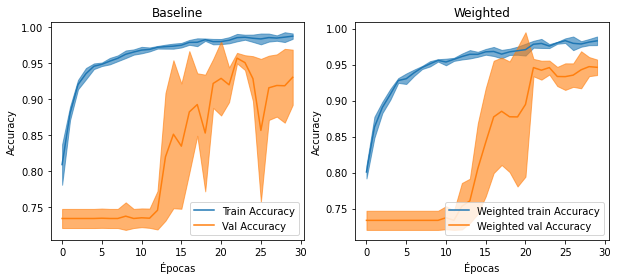

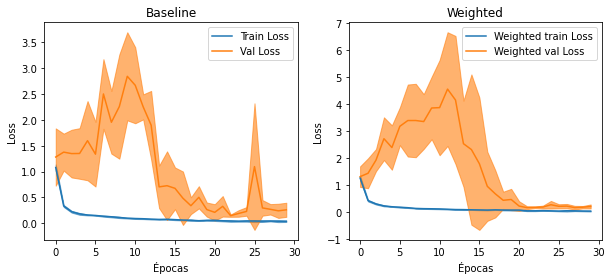

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(train_acc_mean, label = r'Train Accuracy', color = 'C0')
ax1.fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, color = 'C0', alpha = 0.6)
ax1.plot(val_acc_mean, label = r'Val Accuracy', color = 'C1')
ax1.fill_between(epochs, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, color = 'C1', alpha = 0.6)
ax1.set_xlabel(r'Épocas')
ax1.set_ylabel(r'Accuracy')
ax1.set_title('Baseline')
ax1.legend()


ax2.plot(train_acc_meanw, label = r'Weighted train Accuracy', color = 'C0')
ax2.fill_between(epochs, train_acc_meanw - train_acc_stdw, train_acc_meanw + train_acc_stdw, color = 'C0', alpha = 0.6)
ax2.plot(val_acc_meanw, label = r'Weighted val Accuracy', color = 'C1')
ax2.fill_between(epochs, val_acc_meanw - val_acc_stdw, val_acc_meanw + val_acc_stdw, color = 'C1', alpha = 0.6)
ax2.set_title('Weighted')
ax2.set_xlabel(r'Épocas')
ax2.set_ylabel(r'Accuracy')
ax2.legend(loc='lower right')
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(train_loss_mean, label = r'Train Loss', color = 'C0')
ax1.fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color = 'C0', alpha = 0.6)
ax1.plot(val_loss_mean, label = r'Val Loss', color = 'C1')
ax1.fill_between(epochs, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color = 'C1', alpha = 0.6)
ax1.set_xlabel(r'Épocas')
ax1.set_ylabel(r'Loss')
ax1.set_title('Baseline')
ax1.legend()

#--------------------------------------------------------------#

ax2.plot(train_loss_meanw, label = r'Weighted train Loss', color = 'C0')
ax2.fill_between(epochs, train_loss_meanw - train_loss_stdw, train_loss_meanw + train_loss_stdw, color = 'C0', alpha = 0.6)
ax2.plot(val_loss_meanw, label = r'Weighted val Loss', color = 'C1')
ax2.fill_between(epochs, val_loss_meanw - val_loss_stdw, val_loss_meanw + val_loss_stdw, color = 'C1', alpha = 0.6)
ax2.set_xlabel(r'Épocas')
ax2.set_ylabel(r'Loss')
ax2.set_title('Weighted')
ax2.legend()
plt.show()



Pelas imagens, podemos observar que, apesar da loss se coportar melhor depois de muitas épocas, a acurácia varia bastante  em ambos os modelos.

In [15]:
index_best_weights = val_acc.index(max(val_acc))
index_best_weightsw = val_accw.index(max(val_accw))

In [16]:
best_acc = hist[index_best_weights].history['accuracy'][-1]
best_accw = histw[index_best_weightsw].history['accuracy'][-1]

best_loss = hist[index_best_weights].history['loss'][-1]
best_lossw = histw[index_best_weightsw].history['loss'][-1]

best_val_acc = hist[index_best_weights].history['val_accuracy'][-1]
best_val_accw = histw[index_best_weightsw].history['val_accuracy'][-1]

best_val_loss = hist[index_best_weights].history['val_loss'][-1]
best_val_lossw = histw[index_best_weightsw].history['val_loss'][-1]

In [17]:
print(f'Acurácia do melhor modelo: (baseline) { round(best_acc, 5) } vs {round(best_accw,5)} (weighted)')
print(f'Loss do melhor modelo: (baseline) { round(best_loss, 5) } vs {round(best_lossw,5)} (weighted)')
print(f'Acurácia de validação do melhor modelo: (baseline) { round(best_val_acc, 5) } vs {round(best_val_accw,5)} (weighted)')
print(f'Loss de validação do melhor modelo: (baseline) { round(best_val_loss, 5) } vs {round(best_val_lossw,5)} (weighted)')


Acurácia do melhor modelo: (baseline) 0.9912 vs 0.98668 (weighted)
Loss do melhor modelo: (baseline) 0.02212 vs 0.03121 (weighted)
Acurácia de validação do melhor modelo: (baseline) 0.95909 vs 0.94672 (weighted)
Loss de validação do melhor modelo: (baseline) 0.17476 vs 0.25853 (weighted)


Tanto a acurácia quanto a loss dos 2 modelos ficaram muito próximas, tanto para os dados de treino, quanto para os de validação.

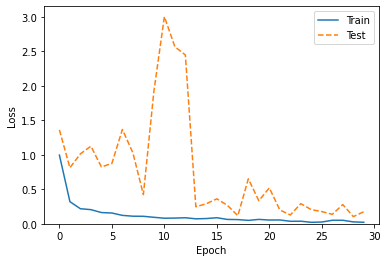

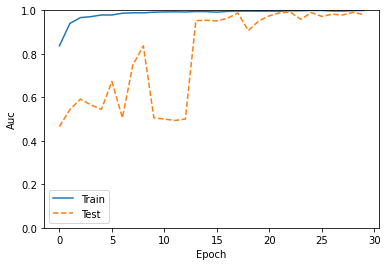

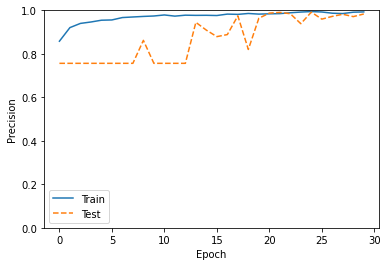

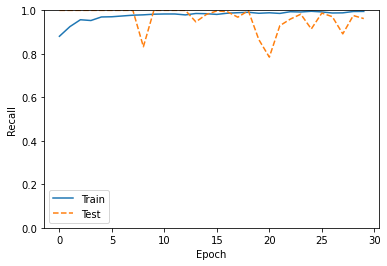

In [18]:
plot_metrics(hist[index_best_weights])

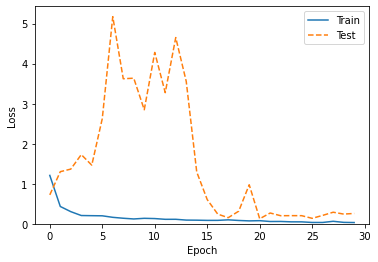

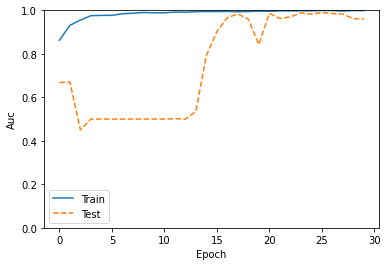

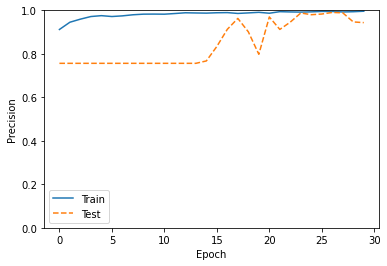

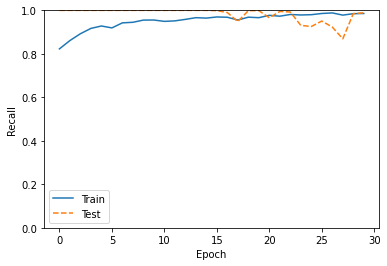

In [19]:
plot_metrics(histw[index_best_weightsw])

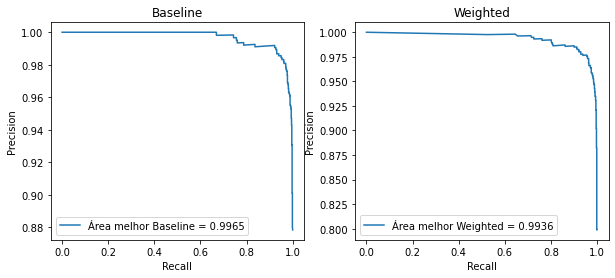

In [20]:
from sklearn.metrics import auc

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(recall[index_best_weights],precision[index_best_weights], label = r'Área melhor Baseline = %.4f'%auc(recall[index_best_weights], precision[index_best_weights]), color = 'C0')

ax1.set_xlabel(r'Recall')
ax1.set_ylabel(r'Precision')
ax1.set_title(r'Baseline')
ax1.legend()



ax2.plot(recallw[index_best_weightsw],precisionw[index_best_weightsw], label = r'Área melhor Weighted = %.4f'%auc(recallw[index_best_weightsw], precisionw[index_best_weightsw]), color = 'C0')

ax2.set_xlabel(r'Recall')
ax2.set_ylabel(r'Precision')
ax2.set_title(r'Weighted')
ax2.legend()

plt.show()

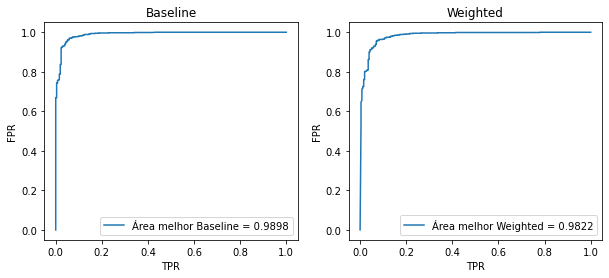

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

ax1.plot(fpr[index_best_weights],tpr[index_best_weights], label = r'Área melhor Baseline = %.4f'%auc(fpr[index_best_weights],tpr[index_best_weights]), color = 'C0')

ax1.set_xlabel(r'TPR')
ax1.set_ylabel(r'FPR')
ax1.set_title(r'Baseline')
ax1.legend()

ax2.plot(fprw[index_best_weightsw], tprw[index_best_weightsw], label = r'Área melhor Weighted = %.4f'%auc(fprw[index_best_weightsw], tprw[index_best_weightsw]), color = 'C0')

ax2.set_xlabel(r'TPR')
ax2.set_ylabel(r'FPR')
ax2.set_title(r'Weighted')
ax2.legend()
plt.show()

Tanto na área sob a ROC quanto no gráfico Precision-Recall, os resultados foram muito próximos.

Text(0.5, 24.0, 'Predicted label')

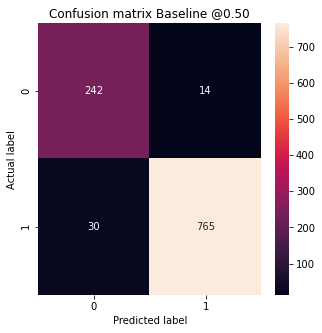

In [23]:
plt.figure(figsize=(5,5))
sns.heatmap(cm[index_best_weights], annot=True, fmt="d")
plt.title('Confusion matrix Baseline @{:.2f}'.format(0.5))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 24.0, 'Predicted label')

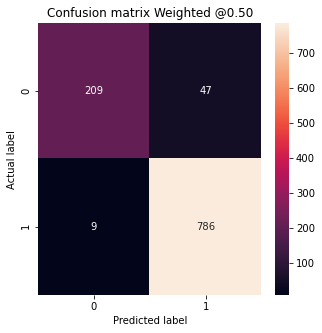

In [24]:
plt.figure(figsize=(5,5))
sns.heatmap(cmw[index_best_weightsw], annot=True, fmt="d")
plt.title('Confusion matrix Weighted @{:.2f}'.format(0.5))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Olhando as matries de confusão, encontramos algo interessante: o modelo baseline tende a ter mais falsos negativos, enquanto o modelo com pesos tende a ter mais falsos positivos.

Como estamos falando em imagens de raio-x de pneumonia em crianças, um falso negativo tem um poder destrutivo muito maior do que um falso positivo. Um falso negativo significa que uma criança doente pode ficar sem medicação e ter sua doença se desenvolvendo. Por isso, nesse caso, o modelo com pesos é preferível, mesmo tendo uma acurácia levemente menor.

Vamos agora usar o LIME, uma biblioteca de explicação de decisões de modelos de inteligência artificial, para visualizar o que o modelo está usando da imagem para fazer a classificação.

In [25]:
pip install lime

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [26]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [27]:
explainer = lime_image.LimeImageExplainer()

In [29]:
%%time
explanation = explainer.explain_instance(x_val[10].astype('double'), modelw.predict, top_labels=5, hide_color=None, num_samples=1000)


CPU times: user 42.7 s, sys: 3.77 s, total: 46.5 s
Wall time: 50.3 s


In [32]:
#Isso nos dirá qual labels ele está considerando como sendo a "positiva".

explanation.top_labels[0]

0

Como ele retornou a label 0, interpretamos resultados verdes como favoráveis à criança estar saudável. Enquanto resultados vermelhos são indicam que a criança está doente.

In [38]:
#Nos dirá qual foi a predição da rede
val_predictions = modelw.predict(x_val)
val_predictions[10]

array([0.0039874], dtype=float32)

In [35]:
#Nos dirá qual era o real resultado
y_val[10]

0

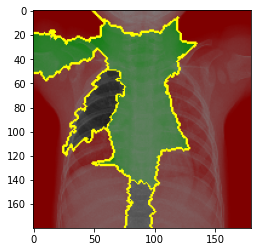

In [41]:
#Estamos diante de um exemplo em que a rede acertou, vejamos quais partes da imagem foram mais relevantes para essa decisão.
#Lembrando que estamos de olho no verde, nesse caso

from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.01)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Vejamos também um exemplo em que o raio-x indica um pulmão doente

In [42]:
y_val[0]

1

In [43]:
val_predictions[0]

array([1.], dtype=float32)

In [44]:
explanation = explainer.explain_instance(x_val[0].astype('double'), modelw.predict, top_labels=5, hide_color=None, num_samples=1000)

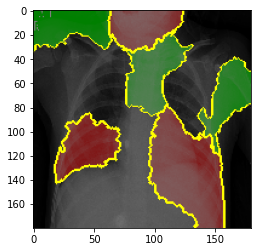

In [49]:
#Estamos novamente diante de um exemplo em que a rede acertou.
#Lembrando que estamos de olho no vermelho, nesse caso

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.05)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Para terminar, vamos ver um exemplo em que a rede errou.

In [54]:
y_val[9]

0

In [55]:
val_predictions[9]

array([0.84792626], dtype=float32)

No caso, estamos diante de um falso positivo

In [56]:
explanation = explainer.explain_instance(x_val[9].astype('double'), modelw.predict, top_labels=5, hide_color=None, num_samples=1000)

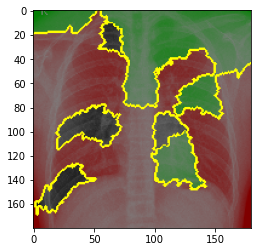

In [60]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.01)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Nesse caso, ela deu maior peso para as partes vermelhas, quando na verdade as verdes deveriam ser mais importantes. Interessante notar que, nessa imagem, a rede baseline acertou. Vamos dar uma olhada rápida na imagem que ela gera.

In [62]:
base_val_predictions = model.predict(x_val)
base_val_predictions[9]

array([0.00036106], dtype=float32)

In [63]:
explanation = explainer.explain_instance(x_val[9].astype('double'), model.predict, top_labels=5, hide_color=None, num_samples=1000)

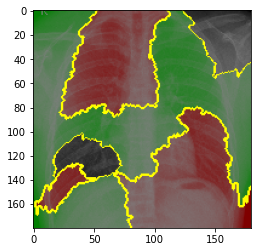

In [66]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.0001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Mais melhorias podem certamente serem feitas na rede. Desde testes com redes mais profundas até variações nos hiperparâmetros, o que pode ser desenvolvido futuramente. Mas estamos diante de um modelo com alta precisão, que já nos traz bons resultados.